In [20]:
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.domains import GridWorld
from msdm.algorithms import ValueIteration
from msdm.core.problemclasses.mdp import TabularPolicy
import numpy as np
import torch
from frozendict import frozendict


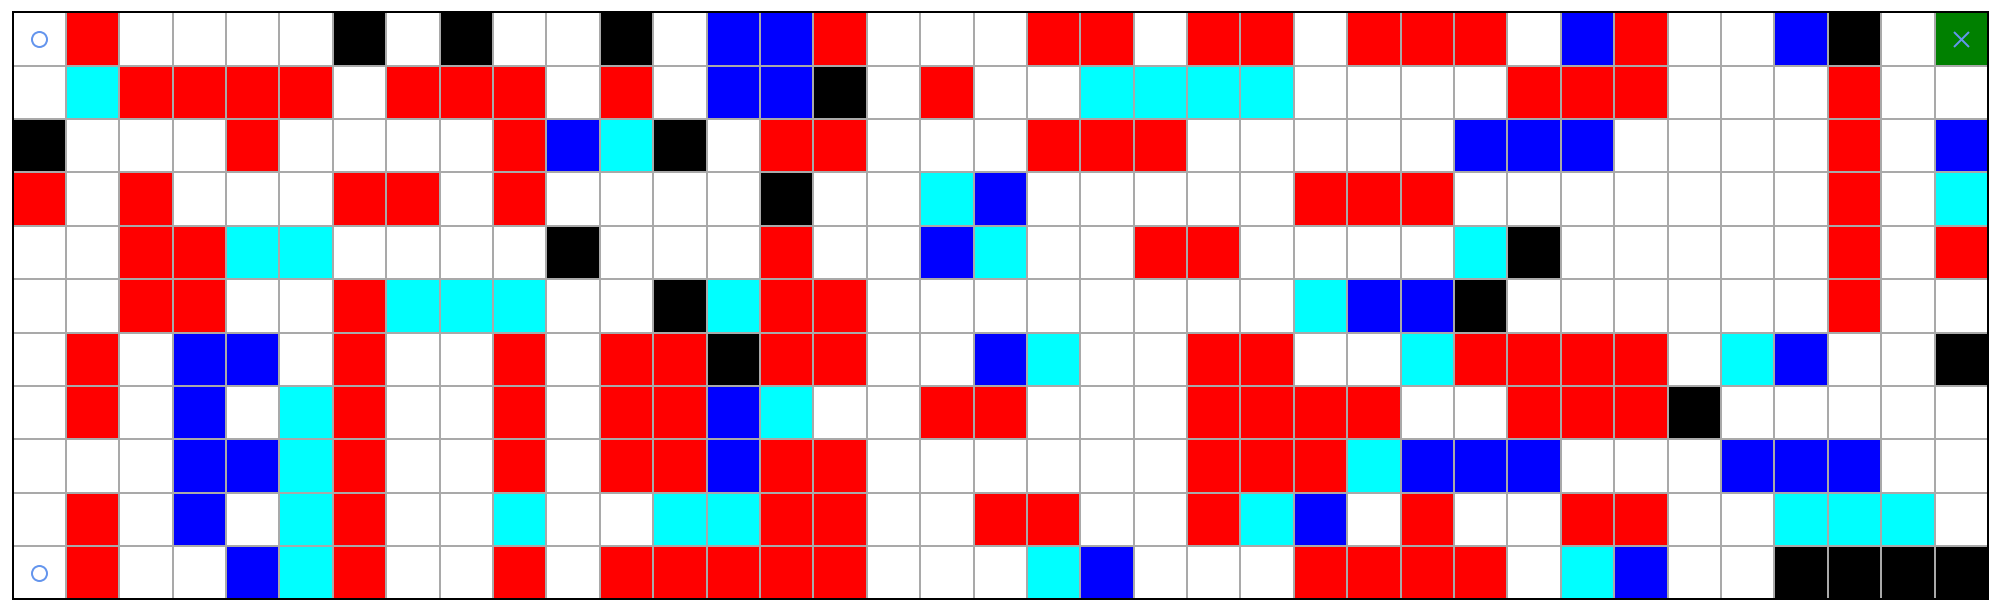

In [21]:
# Create a gridworld
mdp_params = dict(
    tile_array=[
        "sx....c.c..c.bbx...xx.xx.xxx.bx..bc.g",
        ".axxxx.xxx.x.bbc.x..aaaa....xxx...x..",
        "c...x....xbac.xx...xxx.....bbb....x.b",
        "x.x...xx.x....c..ab.....xxx.......x.a",
        "..xxaa....c...x..ba..xx....ac.....x.x",
        "..xx..xaaa..caxx........abbc......x..",
        ".x.bb.x..x.xxcxx..ba..xx..axxxx.ab..c",
        ".x.b.ax..x.xxba..xx...xxxx..xxxc.....",
        "...bbax..x.xxbxx......xxxabbb...bbb..",
        ".x.b.ax..a..aaxx..xx..xab.x..xx..aaa.",
        "sx..bax..x.xxxxx...ab...xxxx.ab..cccc",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp = GridWorld(**mdp_params)

featurecolors = {
    'g': 'green',
    'x': 'red',
    '.': 'white',
    'b': 'blue',
    'a': 'cyan',
    'c': 'black'
}
mdp.plot(featurecolors=featurecolors)


In [22]:
# {frozendict({'dx': 1, 'dy': 0}): 0, frozendict({'dx': -1, 'dy': 0}): 1, frozendict({'dx': 0, 'dy': 0}): 2, frozendict({'dy': 1, 'dx': 0}): 3, frozendict({'dy': -1, 'dx': 0}): 4}

def buildFeatures(mdp, features):
  # each state is a one-hot vector of its color
  state_feature_matrix = torch.zeros(len(mdp.state_list), len(features))
  states = mdp.state_index
  
  for state, state_index in states.items():
    f = mdp.location_features.get(state, '.')
    if f in features:
      feature_index = features.index(f)
    else:
      continue
    state_feature_matrix[state_index, feature_index] = 1

  # shape is 1 (state) x 1 (action) x num_states x num_features bc the features only depend on the next_state so for any state and any action, if it ends in next_state i, it should have the features corresponding to next_state i
  state_action_nextstate_feature_matrix = state_feature_matrix[None, None, :]
  return state_action_nextstate_feature_matrix.double()


def create_step_cost_matrix(mdp):
  # action at every state has a step cost, except the terminal state
  state_step_cost_matrix = torch.tensor(mdp.step_cost) * mdp.nonterminal_state_vec
  
  # shape is num_states (state) x 1 (action) x 1 (next_state) bc the step cost is only dependent on the action you take in the current state. Since it is the same for all actions (and what next_state you end up at), we only need to encode it for the 26 states 
  step_cost_matrix = state_step_cost_matrix[:, None, None]
  return step_cost_matrix

# get features_matrix and feature_reward_weights
features = sorted(mdp_params['feature_rewards'].keys())
features = [f for f in features if f not in 'gs']
feature_matrix = buildFeatures(mdp, features)

# note we do not have these. These need to be randomized
# feature_reward_weights = torch.tensor([float(mdp_params['feature_rewards'][f]) for f in features])
# feature_reward_matrix = torch.einsum(
#     "sanf,f->san",
#     feature_matrix,
#     feature_reward_weights
# ).double()

# step_cost_matrix = create_step_cost_matrix(mdp)
# # construct the reward function
# reward_matrix = feature_reward_matrix + step_cost_matrix

# # this should be |S| x 1 x |S| since its the same for all actions
# assert tuple(reward_matrix.shape) == (len(mdp.state_list), 1, len(mdp.state_list))
    
# # anything leading to the terminal state ({-1, -1}) has zero reward
# terminal_index = mdp.state_index.get(frozendict({'x': -1, 'y': -1}))
# reward_matrix[:, :, terminal_index] = 0

def buildTrajWeights(trajectories):
  trajectories = np.array(trajectories)
  num_trajs = len(trajectories)
  trajectory_weights = torch.zeros(num_trajs, dtype=torch.float64)
  for traj_i, trajectory in enumerate(trajectories):
    # need the normalization factor or else the gradients are too large
    trajectory_weights[traj_i] = np.count_nonzero(trajectories==trajectory) / num_trajs
    # trajectory_weights[traj_i] = np.count_nonzero(trajectories == trajectory)

  return trajectory_weights


In [23]:
def maxLikelihoodIRL(mdp, feature_matrix: torch.Tensor, trajectories, trajectory_weights, iters=50, lr=1):
  '''
  Parameters:
    mdp: a representation of the Markov Decision Process (x-coords, y-coords, color of states, and transition probabilities)
    feature_matrix: S | 1 x A | 1 x S x M where the arr[i, j, k, :] = the features of taking action j in state i and transitioning to state k
    0 <= i, k <= S - 1 and 0 <= j <= A - 1
    trajectories: array of trajectories which are dictionaries containing the state and action trajectory
    trajectory_weights: trajectory-specific weight denoting the frequency of trajectory i
    iters: number of iterations of updating reward weights
    lr: learning rates for each iteration (scalar or array of length iters)
  Output:
    r_weights: the learned reward weights
  '''

  # randomize weights (randomize it with like He initialization)
  # r_weights = torch.from_numpy(np.random.randn(feature_matrix.shape[-1]))
  r_weights = torch.tensor(np.random.randn(feature_matrix.shape[-1]))
  # print(f"Initial weights: {r_weights}")
  # print(r_weights.grad)
  # try true reward weights to debug - Checked. Has basically the same rewards
  # r_weights = torch.tensor([float(mdp_params['feature_rewards'][f]) for f in features]).double()

  r_weights.requires_grad = True
  # every action has a cost associated with taking it
  step_cost_matrix = create_step_cost_matrix(mdp)
  discount_rate = torch.tensor(mdp.discount_rate)
  # transition_matrix = torch.from_numpy(mdp.transition_matrix)
  transition_matrix = torch.tensor(mdp.transition_matrix)
  entropy_weight = 1
  planning_iters = 10
  # features = torch.from_numpy(features)

  optimizer = torch.optim.SGD([r_weights], lr)
  
  for i in range(iters):
    optimizer.zero_grad()

    # build the reward matrix of the entire MDP using current reward weights

    # We do not have the reward weights from MDP bc the reward weights are what we are optimizing. Thus, use r_weights
    feature_reward_matrix = torch.einsum(
        "sanf,f->san",
        feature_matrix,
        r_weights
    )

    # construct the final reward function by taking into account each action's step cost
    reward_matrix = feature_reward_matrix + step_cost_matrix

    # this should be |S| x 1 x |S| since its the same for all actions
    assert tuple(reward_matrix.shape) == (
        len(mdp.state_list), 1, len(mdp.state_list))

    # anything leading to the terminal state ({-1, -1}) has zero reward
    terminal_index = mdp.state_index.get(frozendict({'x': -1, 'y': -1}))
    reward_matrix[:, :, terminal_index] = 0
    
    # compute the optimal policy for the current reward function
    policy = entropy_regularized_policy_iteration(
        transition_matrix, reward_matrix, discount_rate, entropy_weight, planning_iters)
    policy = policy.policy
    loss = torch.tensor(0.0)
    # trajectory = {'state_traj': (1, 2, 3, 4, 5),
    #               'action_traj': (2, 7, 9, 5, 1)}
    for traj_i, trajectory in enumerate(trajectories):
      state_traj = trajectory.get('state_traj')
      action_traj = trajectory.get('action_traj')
      for index in range(len(state_traj)):
        state = state_traj[index]
        action = action_traj[index]
        state_index = mdp.state_index.get(state)
        action_index = mdp.action_index.get(action)
        loss -= torch.log(policy[state_index, action_index]) * trajectory_weights[traj_i]

    loss.backward()
    print(r_weights.grad)
    # r_weights.grad is the value of the gradient of the loss function w/ respect to r_weights
    optimizer.step()
    print(f"Weights after iter {i}: {r_weights}")

  return r_weights


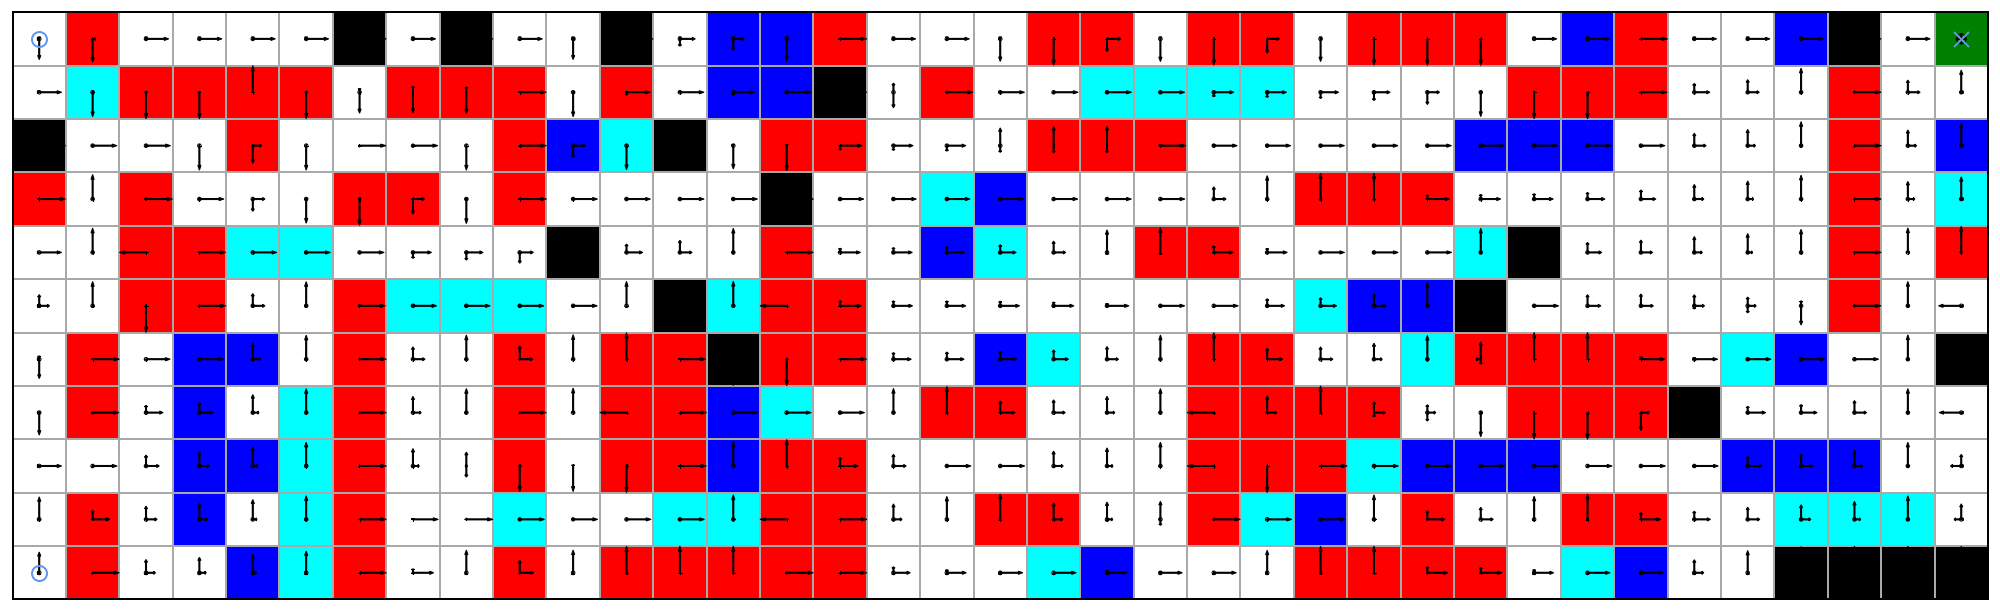

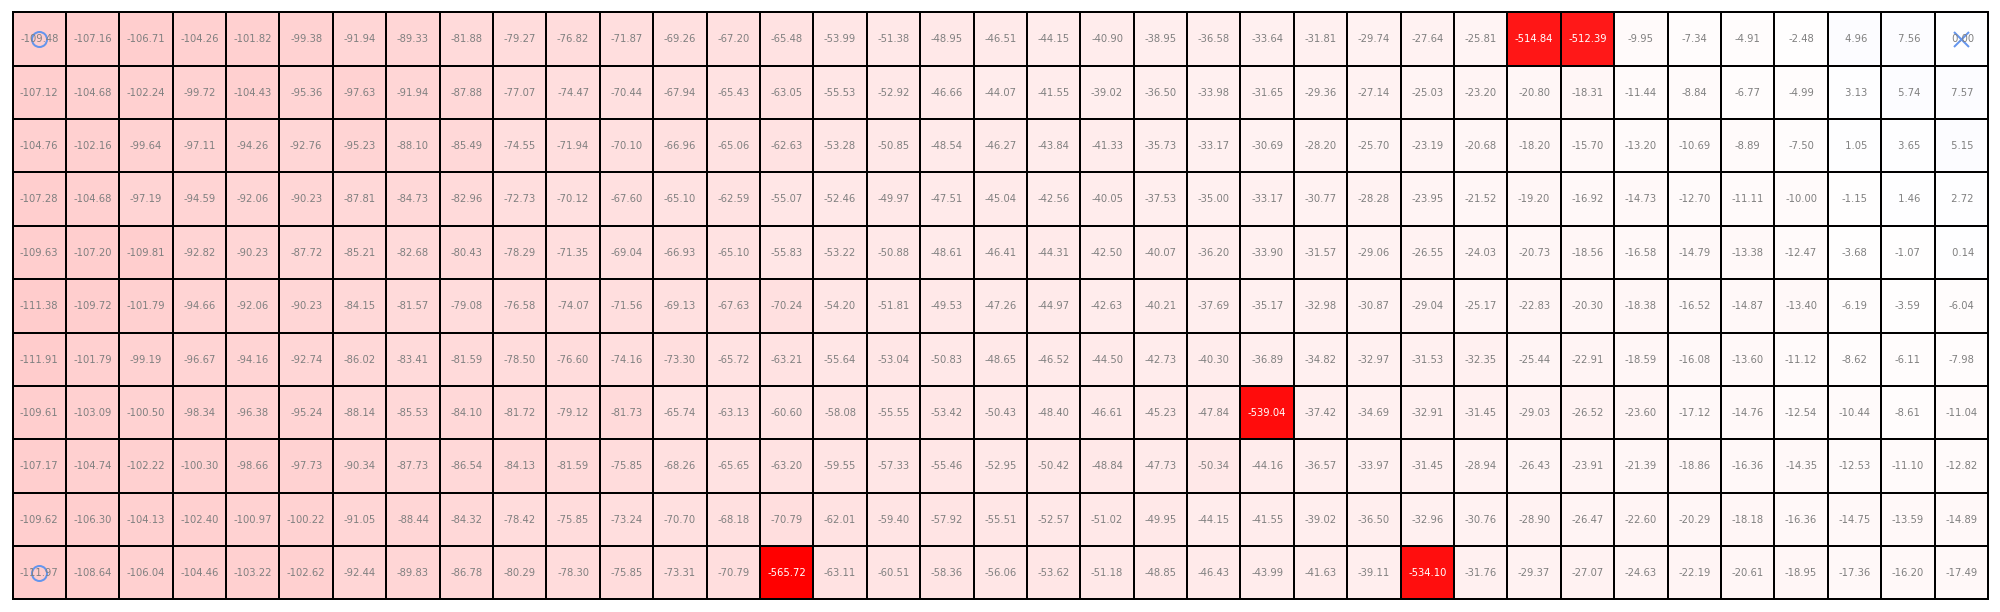

In [24]:
# Expert has a optimal policy
# vi_res = ValueIteration().plan_on(mdp)
# expert_policy = vi_res.policy
# mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)

# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([1]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp.state_list, expert_erpi.state_values))
mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [25]:
# Generate gen_iters of trajectories
gen_iters = 10000
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  # trajectory = {'state_traj': (1, 2, 3, 4, 5),
  #               'action_traj': (2, 7, 9, 5, 1)}
  trajectories.append(formatted_traj)


In [26]:
# Get trajectory_weights
# what does it mean for a trajectory to be equal? only states are equal or both states and actions are equal
trajectory_weights = buildTrajWeights(trajectories)

In [27]:
the_weights = maxLikelihoodIRL(mdp, feature_matrix, trajectories, trajectory_weights, iters=50).detach().numpy()

tensor([ 8.3851e+01, -3.1472e+00,  3.1264e+02,  4.8041e-02,  7.3509e+01],
       dtype=torch.float64)
Weights after iter 0: tensor([-8.4751e+01,  2.3022e+00, -3.1103e+02, -1.7513e-01, -7.3645e+01],
       dtype=torch.float64, requires_grad=True)
tensor([-26.0433,  22.1114,  -5.7962,   1.8098,   8.0983], dtype=torch.float64)
Weights after iter 1: tensor([ -58.7082,  -19.8092, -305.2317,   -1.9849,  -81.7436],
       dtype=torch.float64, requires_grad=True)
tensor([-11.6141,   4.4843,  -6.9958,   0.5831,   5.2810], dtype=torch.float64)
Weights after iter 2: tensor([ -47.0941,  -24.2935, -298.2359,   -2.5680,  -87.0246],
       dtype=torch.float64, requires_grad=True)
tensor([-11.3067,   1.7433,  -6.9958,   2.2128,   5.9945], dtype=torch.float64)
Weights after iter 3: tensor([ -35.7874,  -26.0368, -291.2401,   -4.7808,  -93.0190],
       dtype=torch.float64, requires_grad=True)
tensor([-0.8356, -2.2373, -6.9958,  3.1777,  2.5041], dtype=torch.float64)
Weights after iter 4: tensor([ -34.95

In [28]:
the_weights = torch.tensor(the_weights)

In [29]:
print(f"Final reward weights: {the_weights}")


Final reward weights: tensor([ -18.9546,  -17.5583,  -32.0100,  -54.3411, -135.8925],
       dtype=torch.float64)


In [30]:
step_cost_matrix = create_step_cost_matrix(mdp)

feature_reward_matrix = torch.einsum(
    "sanf,f->san",
    feature_matrix,
    the_weights
)

# construct the final reward function by taking into account each action's step cost
reward_matrix = feature_reward_matrix + step_cost_matrix


In [31]:
my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=reward_matrix,
    discount_rate=torch.tensor(mdp.discount_rate),
    entropy_weight=torch.tensor([1]), # the lower this is, the more optimal the policy
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

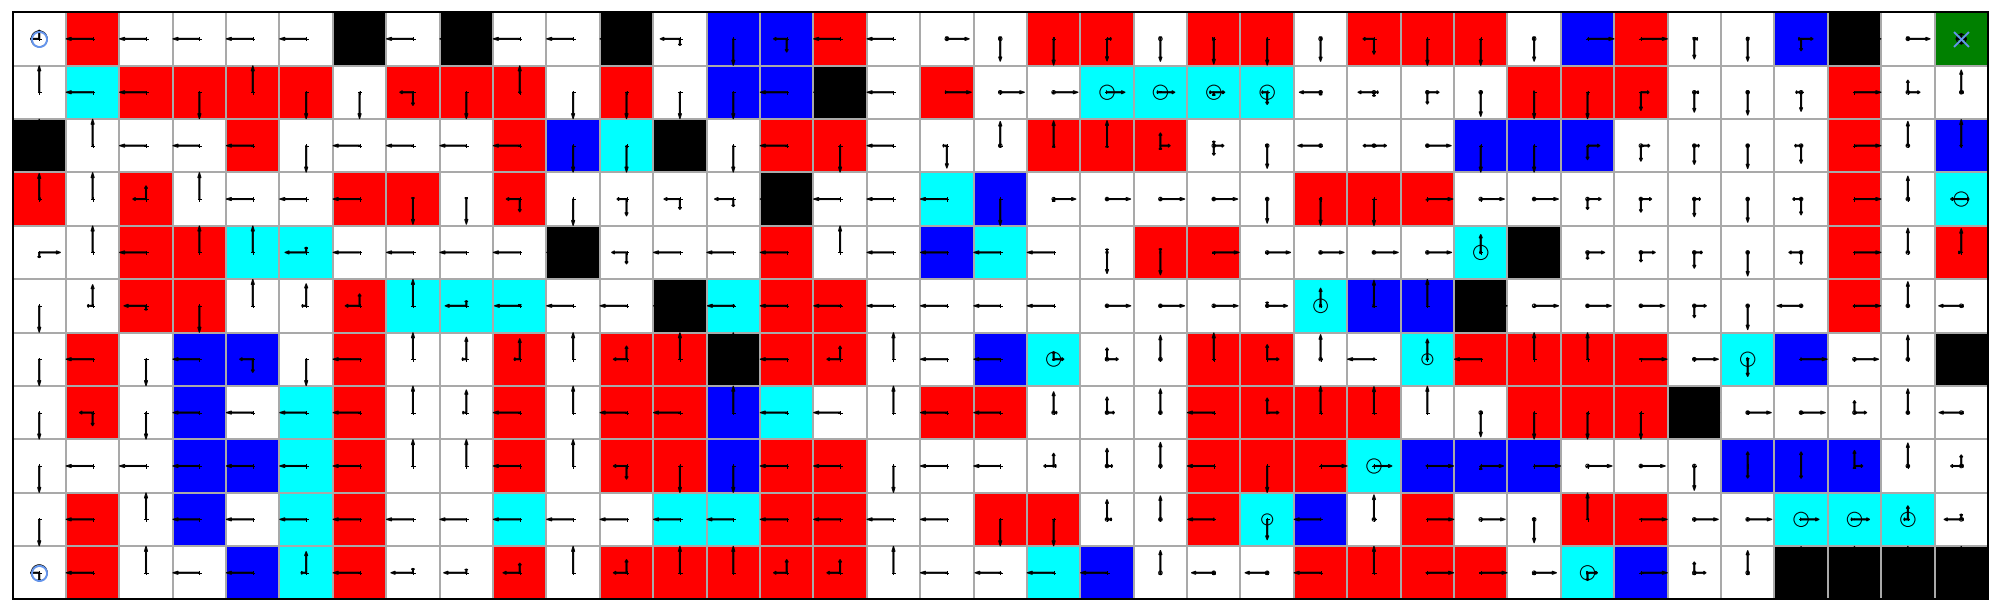

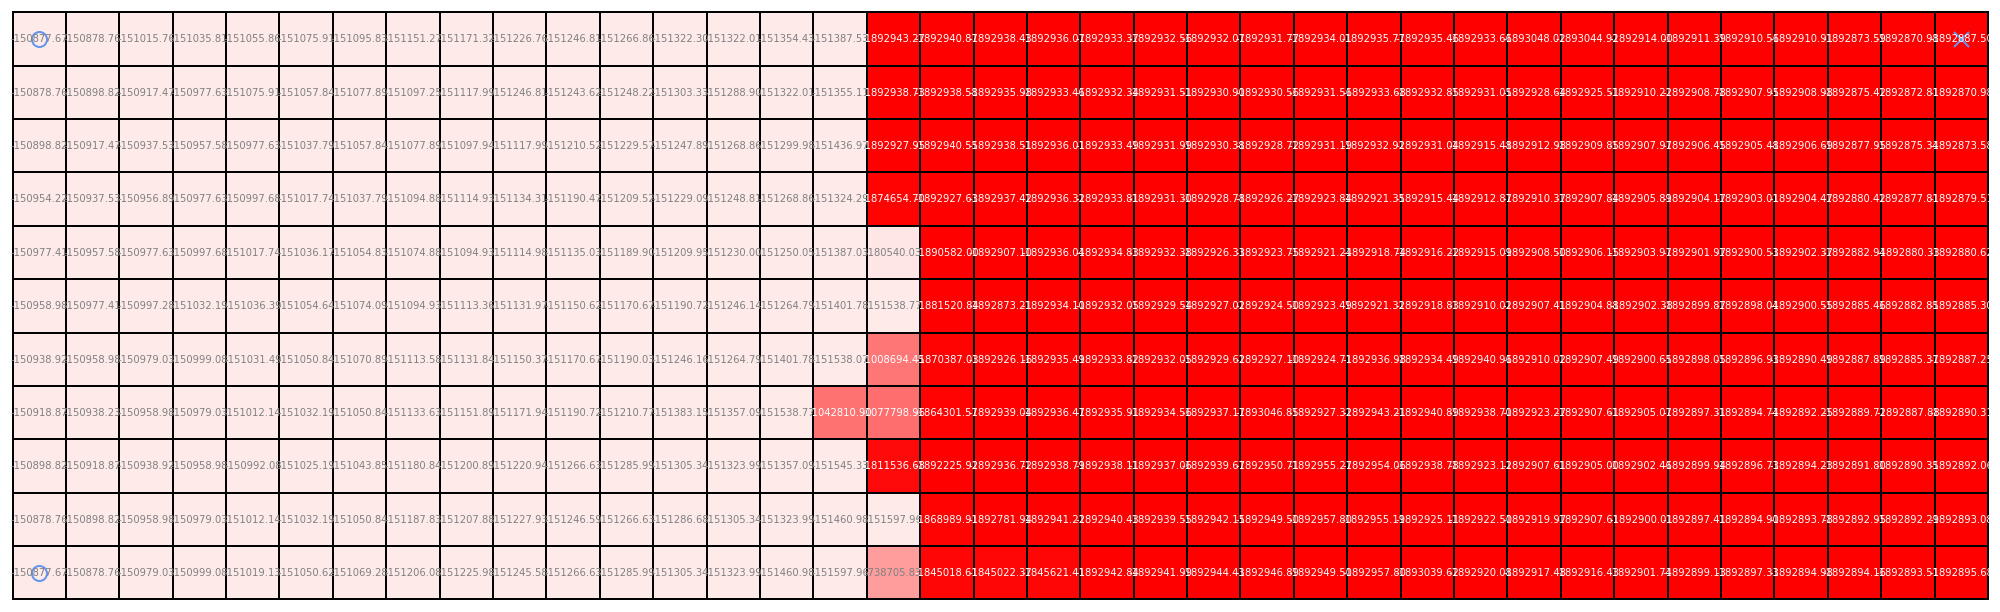

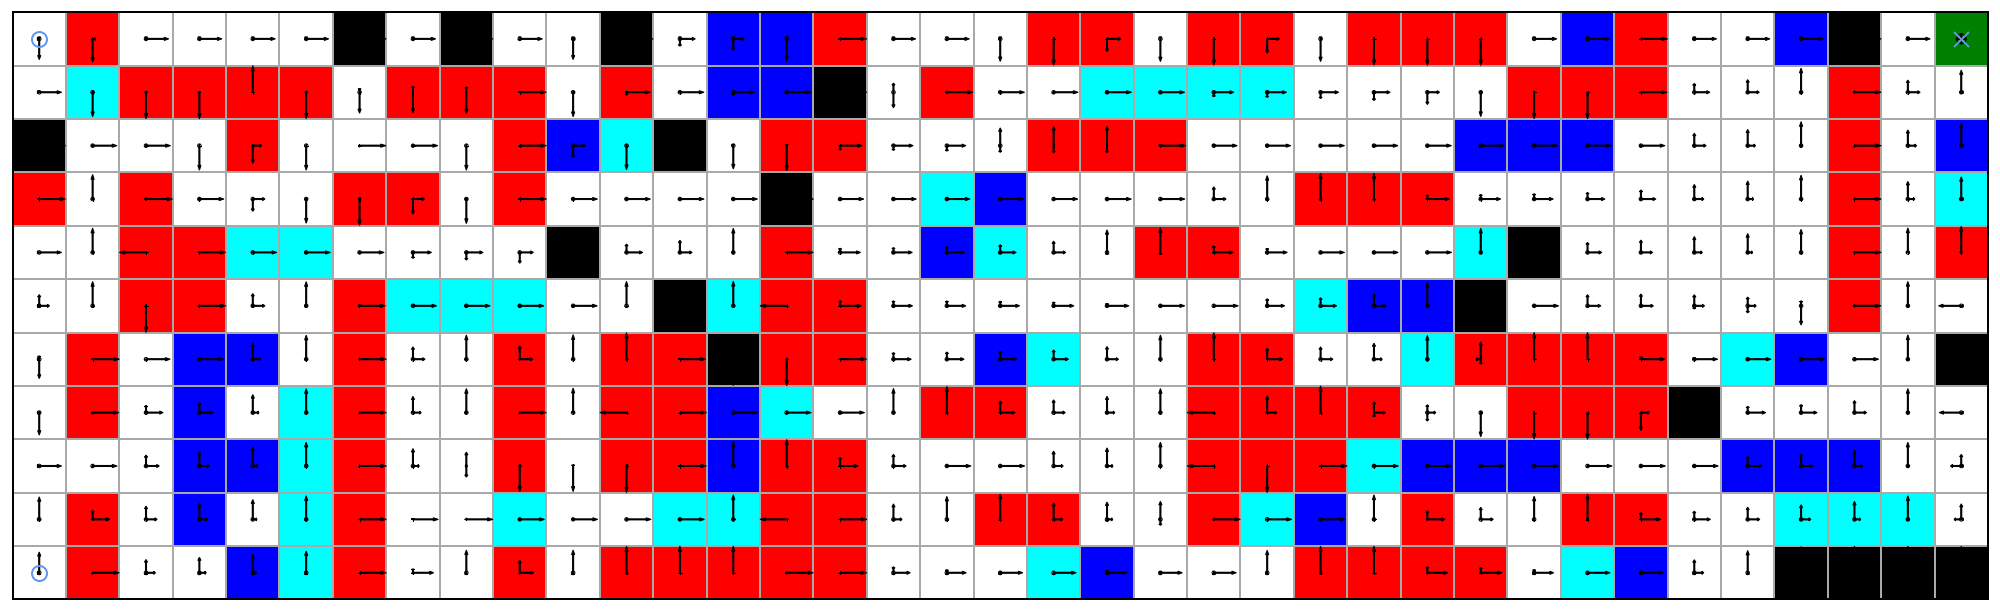

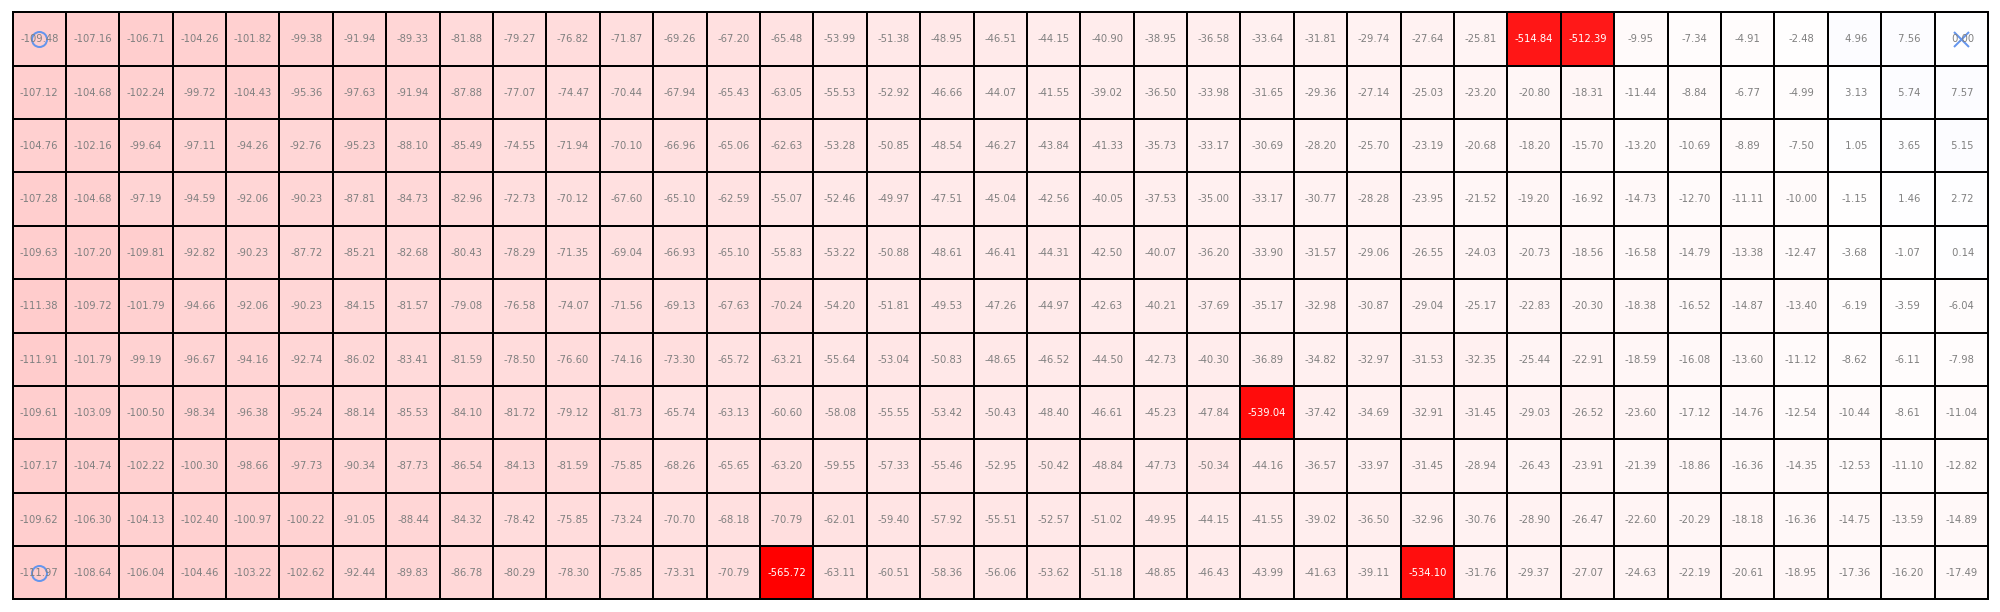

In [32]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)


my_state_values = dict(zip(mdp.state_list, my_erpi.state_values))
mdp.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp.plot().plot_state_map(my_state_values)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [33]:
print(my_policy.evaluate_on(mdp).initial_value)
print(expert_policy.evaluate_on(mdp).initial_value)


-100000.00000045044
-54.23001904455548


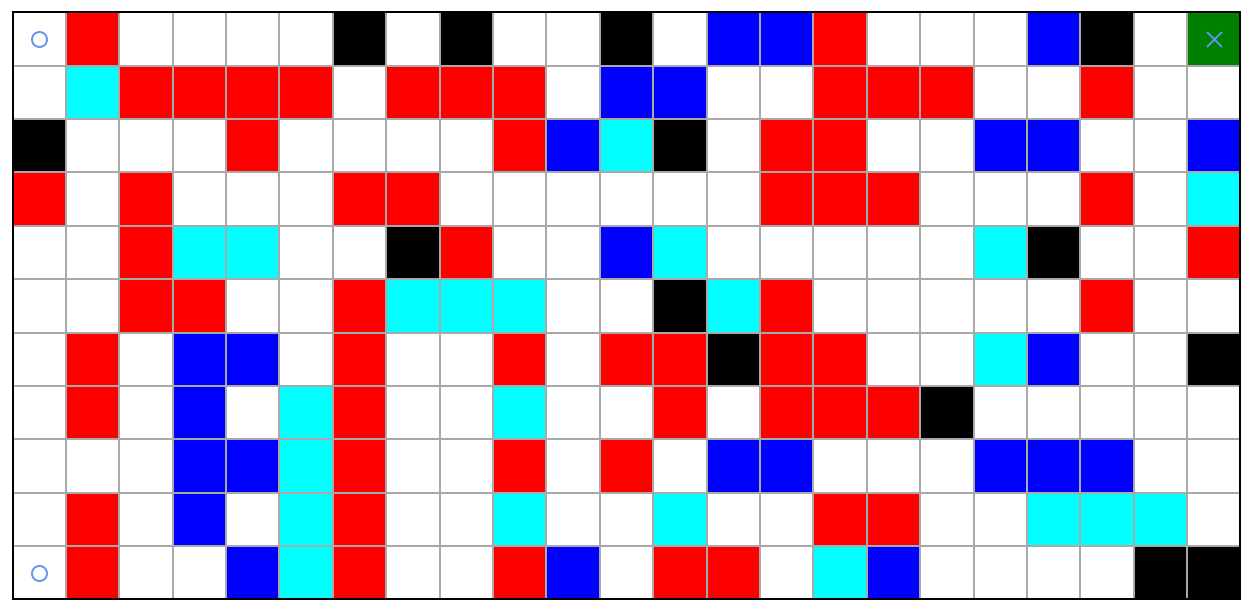

In [34]:
# Test learned reward weights on a novel gridworld
mdp_params2 = dict(
    tile_array=[
        "sx....c.c..c.bbx...bc.g",
        ".axxxx.xxx.bb..xxx..x..",
        "c...x....xbac.xx..bb..b",
        "x.x...xx......xxx...x.a",
        "..xaa..cx..ba.....ac..x",
        "..xx..xaaa..cax.....x..",
        ".x.bb.x..x.xxcxx..ab..c",
        ".x.b.ax..a..x.xxxc.....",
        "...bbax..x.x.bb...bbb..",
        ".x.b.ax..a..a..xx..aaa.",
        "sx..bax..xb.xx.ab....cc",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp2 = GridWorld(**mdp_params2)

mdp2.plot(featurecolors=featurecolors)


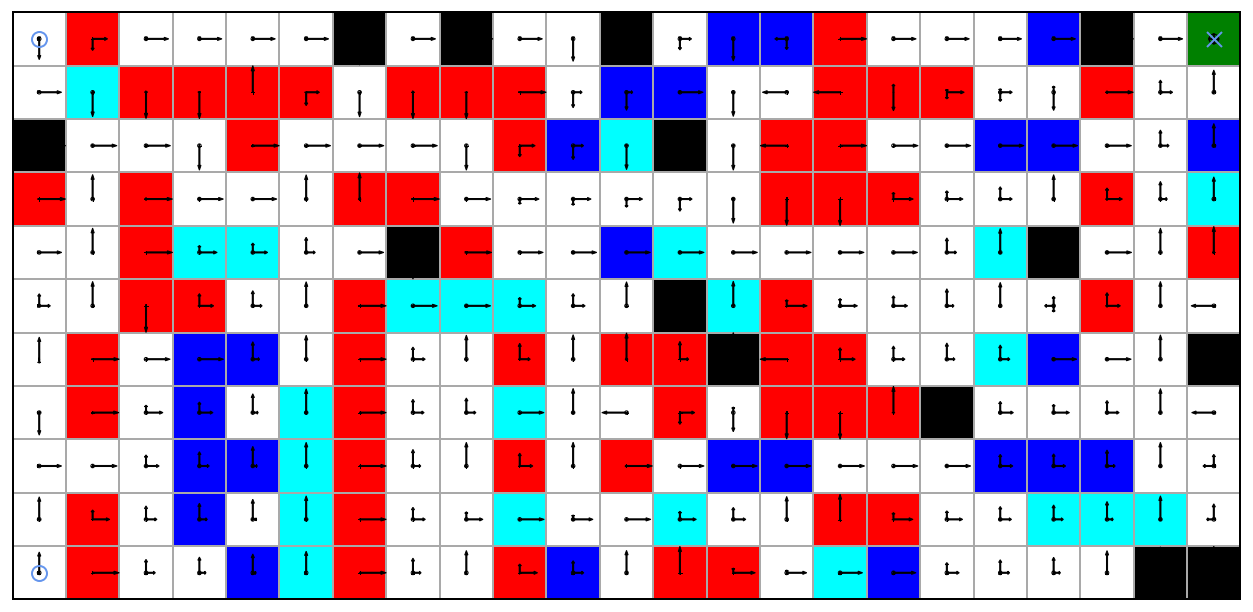

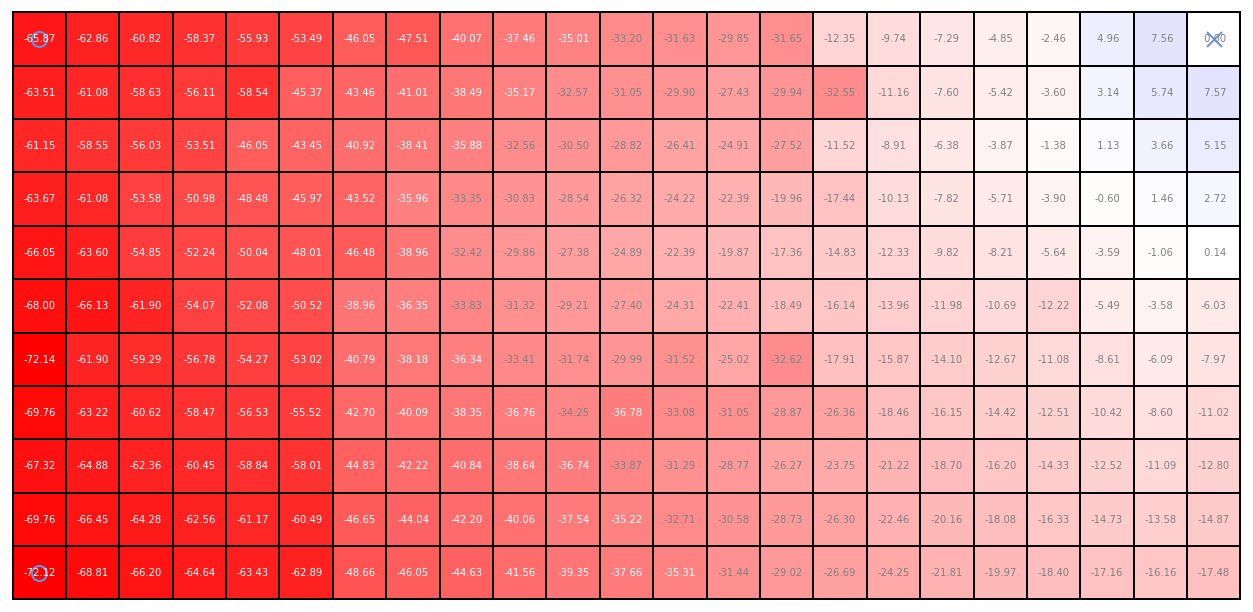

In [35]:
# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([1]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp2.state_list, expert_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)

In [36]:
features = sorted(mdp_params2['feature_rewards'].keys())
features = [f for f in features if f not in 'gs']
feature_matrix = buildFeatures(mdp2, features)

step_cost_matrix = create_step_cost_matrix(mdp2)

feature_reward_matrix = torch.einsum(
    "sanf,f->san",
    feature_matrix,
    the_weights
)

# construct the final reward function by taking into account each action's step cost
reward_matrix = feature_reward_matrix + step_cost_matrix

my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=reward_matrix,
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([1]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


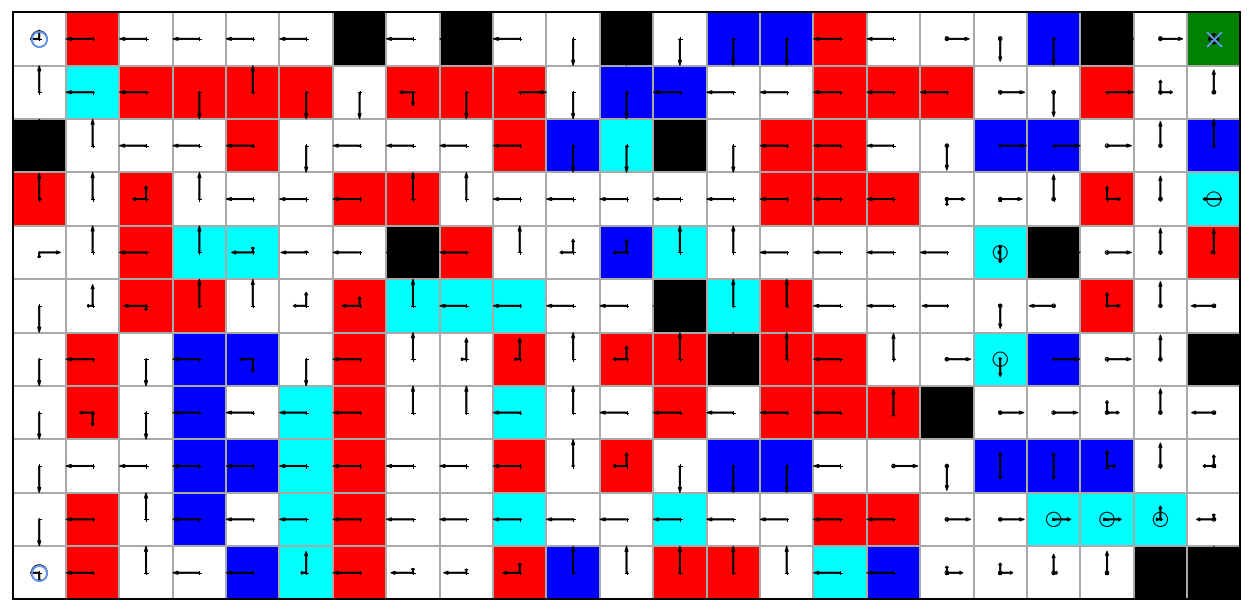

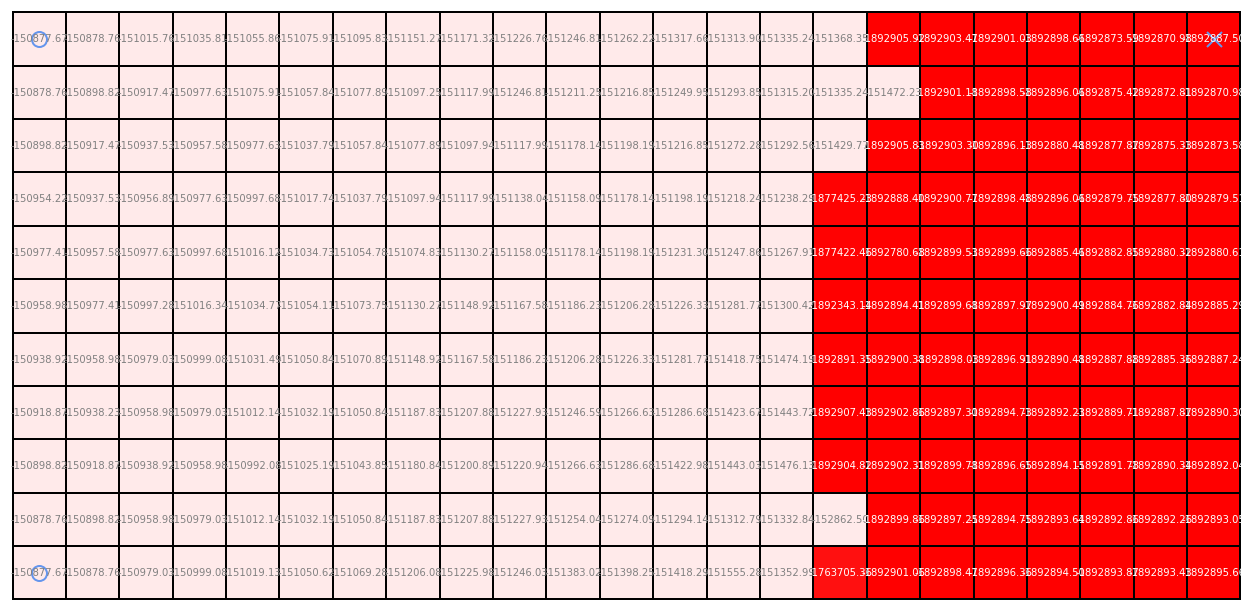

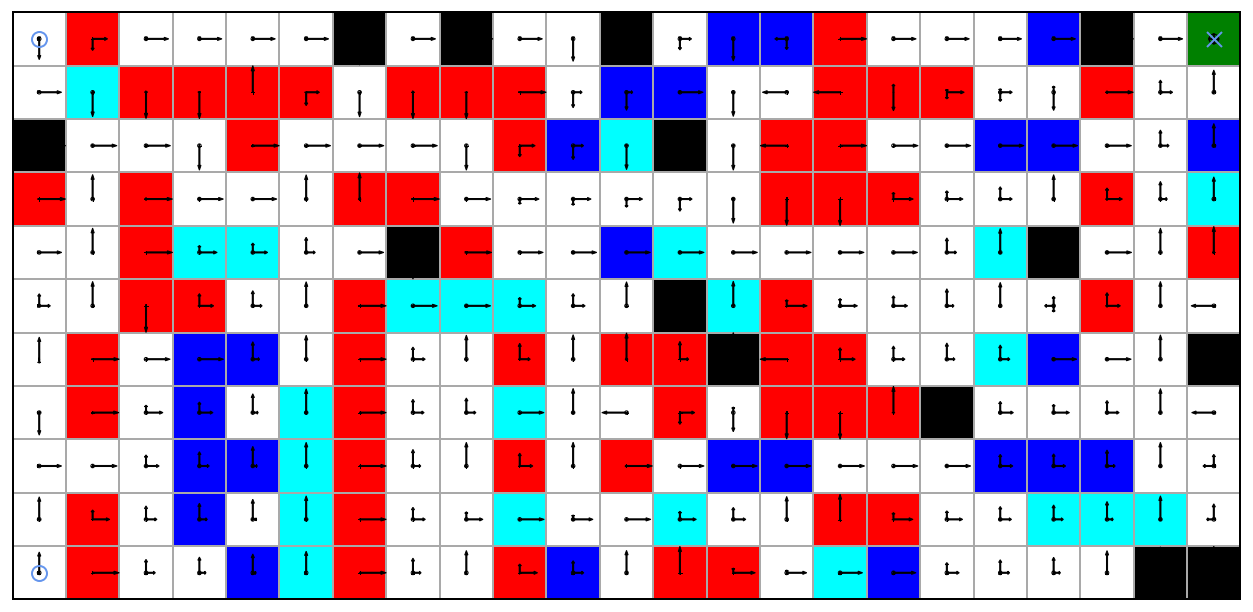

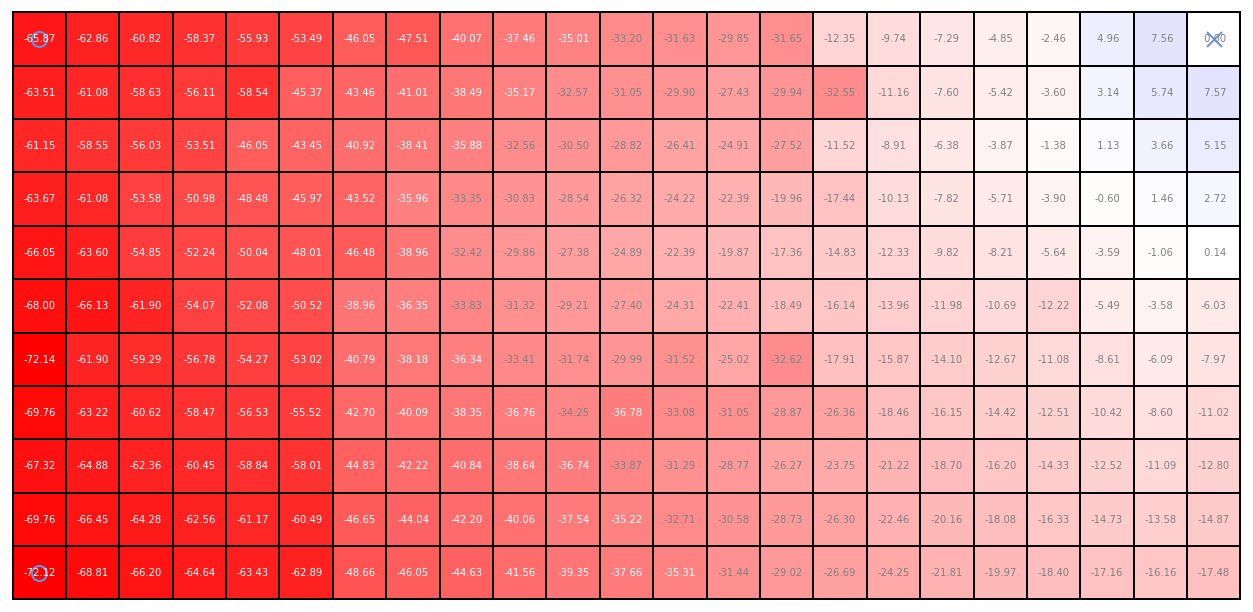

In [37]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)


my_state_values = dict(zip(mdp2.state_list, my_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp2.plot().plot_state_map(my_state_values)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [38]:
print(my_policy.evaluate_on(mdp2).initial_value)
print(expert_policy.evaluate_on(mdp2).initial_value)

-100000.00000046197
-28.85131295508686
